# SAM3 Video/Image-Folder Multi-Prompt Selector

This notebook lets you define prompts interactively on a frame and run SAM3 tracking with them:

- Multiple bounding boxes (positive box prompts)
- Positive and negative point prompts
- Multiple text prompts

Input resource can be either:

- A video file (`.mp4`, `.mov`, ...)
- A folder of JPEG images (`.jpg` / `.jpeg`)

Workflow:

1. Configure resource path and frame index.
2. Draw/select prompts in the interactive canvas.
3. Build prompt payload.
4. Run SAM3 and propagate masks across frames.

Tips:

- In image-folder mode, prompting is applied on the first frame (`FRAME_INDEX=0`).
- Use `%matplotlib widget` for interactive drawing.
- Keyboard shortcuts:
  - `b`: box mode
  - `p`: positive-point mode
  - `n`: negative-point mode
  - `u`: undo last annotation
  - `c`: clear all spatial annotations

In [1]:
%matplotlib widget

from pathlib import Path
import tempfile

import ipywidgets as widgets
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector
import mediapy as media
import numpy as np
from PIL import Image
import torch

from sam3.model_builder import build_sam3_video_predictor

/data/sam3_based_labeling_pipeline/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# --- Configure these ---
# INPUT_RESOURCE_PATH can be either:
# - a video file path (e.g. .mp4, .mov), or
# - a folder containing JPEG images.
INPUT_RESOURCE_PATH = "/data/sam3_based_labeling_pipeline/assets/videos/third_view.mp4"
# INPUT_RESOURCE_PATH = "/data/sam3_based_labeling_pipeline/assets/videos/test_images"
FRAME_INDEX = 0
DEFAULT_OBJECT_ID = 1

# Inference controls
MAX_FRAME_NUM_TO_TRACK = 300
OUTPUT_OVERLAY_VIDEO_PATH = None  # Example: "/data/sam3_based_labeling_pipeline/assets/videos/two_orca_hands_multi_object_overlay.mp4"
OUTPUT_FPS = 24
MASK_ALPHA = 1.0

# Stability setting:
# Disable hole-filling postprocessing to avoid Triton connected-components launch failures
# (useful for high-resolution inputs, regardless of whether source is video or image folder).
DISABLE_HOLE_FILLING = False

In [3]:
resource_path = Path(INPUT_RESOURCE_PATH)
if not resource_path.exists():
    raise FileNotFoundError(f"Resource not found: {resource_path}")


def _ensure_rgb_uint8(img):
    img = np.asarray(img)
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    elif img.ndim == 3 and img.shape[-1] == 4:
        img = img[:, :, :3]
    elif img.ndim == 3 and img.shape[-1] > 4:
        img = img[:, :, :3]
    return np.asarray(img, dtype=np.uint8)


def _resize_longest_side(img, target_longest=1008):
    h, w = img.shape[:2]
    scale = min(1.0, float(target_longest) / float(max(h, w)))
    if scale == 1.0:
        return img

    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    pil_img = Image.fromarray(img)
    pil_img = pil_img.resize((new_w, new_h), resample=Image.BILINEAR)
    return np.asarray(pil_img, dtype=np.uint8)


if resource_path.is_dir():
    # For image-folder mode, only JPEGs are supported here by design.
    frame_paths = [
        p for p in resource_path.iterdir() if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg"}
    ]
    if not frame_paths:
        raise ValueError(f"No JPEG files found in folder: {resource_path}")

    try:
        frame_paths.sort(key=lambda p: int(p.stem))
    except ValueError:
        frame_paths.sort(key=lambda p: p.name)

    original_video_frames = [_ensure_rgb_uint8(media.read_image(str(p))) for p in frame_paths]
    source_kind = "image_folder"

    if FRAME_INDEX != 0:
        print("Image-folder mode uses the first frame for prompting; overriding FRAME_INDEX to 0.")
        FRAME_INDEX = 0
else:
    loaded_video = media.read_video(str(resource_path))
    original_video_frames = [_ensure_rgb_uint8(f) for f in loaded_video]
    source_kind = "video"

if len(original_video_frames) == 0:
    raise ValueError("No frames found in resource")

# Preprocess all frames: RGB-only + resize longest side to 1008.
video_frames = [_resize_longest_side(f, target_longest=1008) for f in original_video_frames]

# Save preprocessed frames into a temporary JPEG folder and run SAM3 on that folder.
preprocessed_dir = Path(tempfile.mkdtemp(prefix="sam3_preprocessed_frames_"))
for idx, frm in enumerate(video_frames):
    Image.fromarray(frm).save(preprocessed_dir / f"{idx:06d}.jpg", quality=95)
model_resource_path = preprocessed_dir

video_frames = np.stack(video_frames, axis=0)
original_video_frames = np.stack(original_video_frames, axis=0)

num_frames = len(video_frames)
if not (0 <= FRAME_INDEX < num_frames):
    raise ValueError(f"FRAME_INDEX must be in [0, {num_frames - 1}], got {FRAME_INDEX}")

frame = np.asarray(video_frames[FRAME_INDEX], dtype=np.uint8)
height, width = frame.shape[:2]
orig_h, orig_w = original_video_frames[FRAME_INDEX].shape[:2]

print(f"Loaded {source_kind}: {resource_path}")
print(f"Total frames: {num_frames}")
print(f"Selected frame: {FRAME_INDEX}")
print(f"Prompt/model frame size (width x height): {width} x {height}")
print(f"Original frame size (width x height): {orig_w} x {orig_h}")
print(f"Model resource path: {model_resource_path}")

Loaded video: /data/sam3_based_labeling_pipeline/assets/videos/third_view.mp4
Total frames: 115
Selected frame: 0
Prompt/model frame size (width x height): 960 x 540
Original frame size (width x height): 960 x 540
Model resource path: /tmp/sam3_preprocessed_frames_8pqtn_27


Output()

Interactive multi-object annotator ready.
For each object, set text + box first. Optionally add a positive hand point for second-pass refinement.


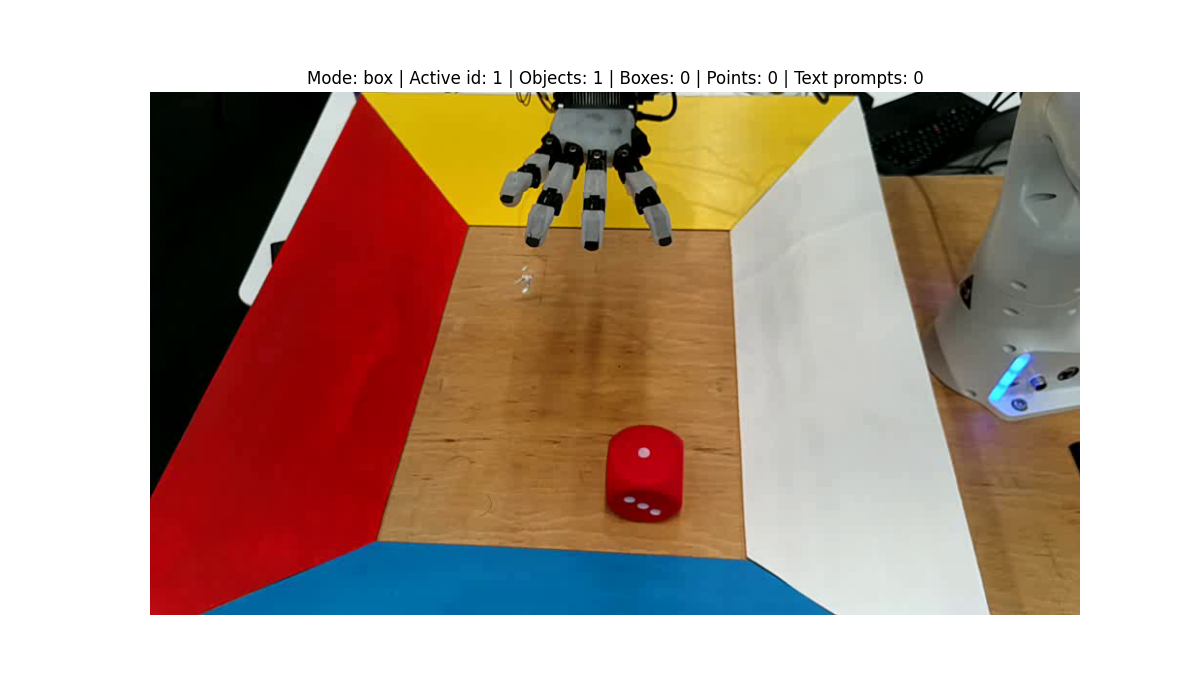

In [4]:
annotations_by_obj = {}
history = []  # list[tuple[str, int]] where tuple = (kind, obj_id)
mode_state = {"value": "box"}
active_obj_state = {"id": int(DEFAULT_OBJECT_ID)}
rng = np.random.default_rng()


def _random_color_rgb():
    # Keep colors bright so masks are visible on most videos.
    color = rng.integers(40, 256, size=3, dtype=np.int32)
    return tuple(int(c) for c in color)


def _ensure_object(obj_id):
    obj_id = int(obj_id)
    if obj_id not in annotations_by_obj:
        annotations_by_obj[obj_id] = {
            "boxes_xyxy": [],
            "box_labels": [],  # 1 = positive box prompt
            "points_xy": [],
            "point_labels": [],  # 1 = positive point, 0 = negative point
            "text_prompt": "",
            "color_rgb": _random_color_rgb(),
        }
    return annotations_by_obj[obj_id]


def _clip_xy(x, y):
    x = int(round(max(0, min(x, width - 1))))
    y = int(round(max(0, min(y, height - 1))))
    return x, y


def _mpl_color(rgb):
    return tuple(c / 255.0 for c in rgb)


def _refresh_object_output():
    with object_output:
        clear_output(wait=True)
        if not annotations_by_obj:
            print("No objects yet.")
            return

        print(f"Active object: {active_obj_state['id']}")
        print("Objects:")
        for obj_id in sorted(annotations_by_obj.keys()):
            obj = annotations_by_obj[obj_id]
            color = obj["color_rgb"]
            text = obj["text_prompt"] or "<none>"
            print(
                f"  id={obj_id} color={color} boxes={len(obj['boxes_xyxy'])} "
                f"points={len(obj['points_xy'])} text={text}"
            )


def _render_annotations():
    ax.clear()
    ax.imshow(frame)

    for obj_id in sorted(annotations_by_obj.keys()):
        obj = annotations_by_obj[obj_id]
        color = _mpl_color(obj["color_rgb"])

        for box in obj["boxes_xyxy"]:
            x1, y1, x2, y2 = box
            ax.add_patch(
                Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor=color,
                    linewidth=2,
                )
            )
            ax.text(
                x1,
                max(0, y1 - 5),
                f"id={obj_id}",
                color="white",
                fontsize=9,
                bbox={"facecolor": color, "alpha": 0.8, "pad": 2},
            )

        if obj["points_xy"]:
            points = np.asarray(obj["points_xy"], dtype=np.float32)
            labels = np.asarray(obj["point_labels"], dtype=np.int32)

            pos_points = points[labels == 1]
            neg_points = points[labels == 0]

            if len(pos_points) > 0:
                ax.scatter(
                    pos_points[:, 0],
                    pos_points[:, 1],
                    c=[color],
                    marker="o",
                    s=60,
                    linewidths=1,
                    edgecolors="black",
                )
            if len(neg_points) > 0:
                ax.scatter(
                    neg_points[:, 0],
                    neg_points[:, 1],
                    c=[color],
                    marker="x",
                    s=70,
                    linewidths=2,
                )

    total_boxes = sum(len(obj["boxes_xyxy"]) for obj in annotations_by_obj.values())
    total_points = sum(len(obj["points_xy"]) for obj in annotations_by_obj.values())
    total_text = sum(1 for obj in annotations_by_obj.values() if obj["text_prompt"].strip())

    ax.set_axis_off()
    ax.set_title(
        f"Mode: {mode_state['value']} | Active id: {active_obj_state['id']} | "
        f"Objects: {len(annotations_by_obj)} | Boxes: {total_boxes} | "
        f"Points: {total_points} | Text prompts: {total_text}"
    )
    fig.canvas.draw_idle()


def _set_mode(new_mode):
    mode_state["value"] = new_mode
    selector.set_active(new_mode == "box")
    mode_toggle.value = new_mode
    _render_annotations()


def _select_or_create_object(_=None):
    obj_id = int(object_id_input.value)
    active_obj_state["id"] = obj_id
    obj = _ensure_object(obj_id)
    object_text_input.value = obj["text_prompt"]
    _refresh_object_output()
    _render_annotations()


def _set_object_text(_=None):
    obj_id = active_obj_state["id"]
    obj = _ensure_object(obj_id)
    obj["text_prompt"] = object_text_input.value.strip()
    history.append(("text", obj_id))
    _refresh_object_output()
    _render_annotations()


def _undo_last(_=None):
    if not history:
        print("Nothing to undo.")
        return

    kind, obj_id = history.pop()
    obj = annotations_by_obj.get(obj_id)
    if obj is None:
        return

    if kind == "box" and obj["boxes_xyxy"]:
        obj["boxes_xyxy"].pop()
        obj["box_labels"].pop()
    elif kind == "point" and obj["points_xy"]:
        obj["points_xy"].pop()
        obj["point_labels"].pop()
    elif kind == "text":
        obj["text_prompt"] = ""

    _refresh_object_output()
    _render_annotations()


def _clear_active_object(_=None):
    obj_id = active_obj_state["id"]
    obj = _ensure_object(obj_id)
    obj["boxes_xyxy"].clear()
    obj["box_labels"].clear()
    obj["points_xy"].clear()
    obj["point_labels"].clear()
    obj["text_prompt"] = ""

    history[:] = [entry for entry in history if entry[1] != obj_id]
    object_text_input.value = ""
    _refresh_object_output()
    _render_annotations()


def _clear_all_objects(_=None):
    annotations_by_obj.clear()
    history.clear()
    active_obj_state["id"] = int(DEFAULT_OBJECT_ID)
    _ensure_object(active_obj_state["id"])
    object_id_input.value = active_obj_state["id"]
    object_text_input.value = ""
    _refresh_object_output()
    _render_annotations()


def _on_select(eclick, erelease):
    if mode_state["value"] != "box":
        return

    if None in (eclick.xdata, eclick.ydata, erelease.xdata, erelease.ydata):
        print("Selection ignored: drag fully inside the image.")
        return

    x1, y1 = _clip_xy(min(eclick.xdata, erelease.xdata), min(eclick.ydata, erelease.ydata))
    x2, y2 = _clip_xy(max(eclick.xdata, erelease.xdata), max(eclick.ydata, erelease.ydata))

    if x2 <= x1 or y2 <= y1:
        print("Invalid box (zero/negative area). Try again.")
        return

    obj = _ensure_object(active_obj_state["id"])
    obj["boxes_xyxy"].append((x1, y1, x2, y2))
    obj["box_labels"].append(1)
    history.append(("box", active_obj_state["id"]))
    _refresh_object_output()
    _render_annotations()


def _on_click(event):
    if event.inaxes != ax:
        return
    if mode_state["value"] not in {"point+", "point-"}:
        return
    if event.xdata is None or event.ydata is None:
        return

    x, y = _clip_xy(event.xdata, event.ydata)
    label = 1 if mode_state["value"] == "point+" else 0

    obj = _ensure_object(active_obj_state["id"])
    obj["points_xy"].append((x, y))
    obj["point_labels"].append(label)
    history.append(("point", active_obj_state["id"]))
    _refresh_object_output()
    _render_annotations()


def _on_key(event):
    key = (event.key or "").lower()
    if key == "b":
        _set_mode("box")
    elif key == "p":
        _set_mode("point+")
    elif key == "n":
        _set_mode("point-")
    elif key == "u":
        _undo_last()


fig, ax = plt.subplots(figsize=(12, 7))
selector = RectangleSelector(
    ax,
    _on_select,
    useblit=True,
    button=[1],
    minspanx=5,
    minspany=5,
    spancoords="pixels",
    interactive=True,
)

fig.canvas.mpl_connect("button_press_event", _on_click)
fig.canvas.mpl_connect("key_press_event", _on_key)

mode_toggle = widgets.ToggleButtons(
    options=[("Box", "box"), ("Positive Point", "point+"), ("Negative Point", "point-")],
    value="box",
    description="Mode:",
)


def _on_mode_toggle(change):
    if change["name"] == "value" and change["new"] != mode_state["value"]:
        _set_mode(change["new"])


mode_toggle.observe(_on_mode_toggle)

object_id_input = widgets.IntText(value=int(DEFAULT_OBJECT_ID), description="Object ID:")
select_object_button = widgets.Button(description="Select/Create Object", button_style="info")
select_object_button.on_click(_select_or_create_object)

object_text_input = widgets.Text(
    description="Text:",
    placeholder="Object-specific text prompt",
    layout=widgets.Layout(width="550px"),
)
set_text_button = widgets.Button(description="Set Object Text", button_style="success")
set_text_button.on_click(_set_object_text)

undo_button = widgets.Button(description="Undo", button_style="")
clear_active_button = widgets.Button(description="Clear Active Object", button_style="warning")
clear_all_button = widgets.Button(description="Clear All Objects", button_style="danger")
undo_button.on_click(_undo_last)
clear_active_button.on_click(_clear_active_object)
clear_all_button.on_click(_clear_all_objects)

object_output = widgets.Output()

control_row_1 = widgets.HBox([mode_toggle, undo_button, clear_active_button, clear_all_button])
control_row_2 = widgets.HBox([object_id_input, select_object_button])
control_row_3 = widgets.HBox([object_text_input, set_text_button])

display(control_row_1)
display(control_row_2)
display(control_row_3)
display(object_output)

_ensure_object(active_obj_state["id"])
_select_or_create_object()
_render_annotations()
print("Interactive multi-object annotator ready.")
print("For each object, set text + box first. Optionally add a positive hand point for second-pass refinement.")

In [6]:
def xyxy_pixels_to_xywh_norm(box_xyxy, image_width, image_height):
    x1, y1, x2, y2 = [float(v) for v in box_xyxy]
    if x2 <= x1 or y2 <= y1:
        raise ValueError(f"Invalid XYXY box with non-positive size: {box_xyxy}")
    return [
        x1 / image_width,
        y1 / image_height,
        (x2 - x1) / image_width,
        (y2 - y1) / image_height,
    ]


def points_pixels_to_norm(points_xy, image_width, image_height):
    if len(points_xy) == 0:
        return []
    points = np.asarray(points_xy, dtype=np.float32)
    points[:, 0] /= image_width
    points[:, 1] /= image_height
    return points.tolist()


def build_object_prompt_plan(strict=True):
    object_plans = []
    invalid_objects = []

    for obj_id in sorted(annotations_by_obj.keys()):
        obj = annotations_by_obj[obj_id]
        has_boxes = len(obj["boxes_xyxy"]) > 0
        has_points = len(obj["points_xy"]) > 0
        has_text = bool(obj["text_prompt"].strip())
        has_any_prompt = has_boxes or has_points or has_text

        if not has_any_prompt:
            continue

        # Required baseline combination:
        # - box + text (stage 1)
        # Optional refinement:
        # - positive/negative points (stage 2)
        is_valid = has_boxes and has_text
        if not is_valid:
            invalid_objects.append(
                f"obj_id={obj_id} invalid: provide (bounding box + text)"
            )
            continue

        normal_payload = None
        if has_text and has_boxes:
            normal_payload = {
                "obj_id": int(obj_id),
                "frame_index": FRAME_INDEX,
                "text": obj["text_prompt"].strip(),
            }
            normal_payload["bounding_boxes"] = [
                xyxy_pixels_to_xywh_norm(box, width, height)
                for box in obj["boxes_xyxy"]
            ]
            normal_payload["bounding_box_labels"] = obj["box_labels"].copy()

        point_payload = None
        if has_points:
            positive_points_xy = [
                pt for pt, lbl in zip(obj["points_xy"], obj["point_labels"]) if int(lbl) == 1
            ]
            if positive_points_xy:
                points_norm = points_pixels_to_norm(positive_points_xy, width, height)
                point_payload = {
                    "obj_id": int(obj_id),
                    "frame_index": FRAME_INDEX,
                    "points": torch.tensor(points_norm, dtype=torch.float32),
                    "point_labels": torch.ones(len(points_norm), dtype=torch.int32),
                }

        object_plans.append(
            {
                "obj_id": int(obj_id),
                "color_rgb": tuple(obj["color_rgb"]),
                "normal_payload": normal_payload,
                "point_payload": point_payload,
            }
        )

    if strict and invalid_objects:
        raise ValueError("\n".join(invalid_objects))

    return object_plans, invalid_objects


object_plans, invalid_objects = build_object_prompt_plan(strict=False)
print(f"Prepared prompt plan for {len(object_plans)} object(s)")

if invalid_objects:
    print("Invalid objects (not sent to SAM3 unless fixed):")
    for message in invalid_objects:
        print(f"  - {message}")

for plan in object_plans:
    obj_id = plan["obj_id"]
    print(f"obj_id={obj_id}")

    if plan["normal_payload"] is not None:
        print(f"    text: {plan['normal_payload']['text']}")
        if "bounding_boxes" in plan["normal_payload"]:
            first_box = plan["normal_payload"]["bounding_boxes"][0]
            print("  stage 1: normal propagation seed (box + text)")
            print(f"    first box xywh(norm): {first_box}")
        else:
            print("  stage 1: normal propagation seed (text-only warmup for points+text)")
    else:
        print("  stage 1: no normal prompt for this object")

    if plan["point_payload"] is not None:
        first_point = plan["point_payload"]["points"][0].tolist()
        print("  stage 2: rerun with positive-point refinement")
        print(f"    first positive point(norm): {first_point}")
    else:
        print("  stage 2: no positive points for this object (rerun still happens)")

Prepared prompt plan for 1 object(s)
obj_id=1
    text: robot hand
  stage 1: normal propagation seed (box + text)
    first box xywh(norm): [0.3614583333333333, 0.016666666666666666, 0.23229166666666667, 0.26851851851851855]
  stage 2: rerun with positive-point refinement
    first positive point(norm): [0.4729166626930237, 0.09259258955717087]


In [7]:
def _xywh_norm_to_xyxy_pixels(boxes_xywh, image_width, image_height):
    boxes_xyxy = np.zeros_like(boxes_xywh, dtype=np.float32)
    boxes_xyxy[:, 0] = boxes_xywh[:, 0] * image_width
    boxes_xyxy[:, 1] = boxes_xywh[:, 1] * image_height
    boxes_xyxy[:, 2] = (boxes_xywh[:, 0] + boxes_xywh[:, 2]) * image_width
    boxes_xyxy[:, 3] = (boxes_xywh[:, 1] + boxes_xywh[:, 3]) * image_height
    return boxes_xyxy


def _to_binary_mask(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    mask = np.asarray(mask)
    while mask.ndim > 2:
        mask = mask[0]
    return mask > 0.0


def _blend_masks_on_frame(raw_frame, frame_outputs, object_colors_rgb, alpha=0.45):
    raw_frame = _ensure_rgb_uint8(raw_frame)
    overlay = raw_frame.astype(np.float32).copy()
    if frame_outputs is None or len(frame_outputs["object_ids"]) == 0:
        return raw_frame

    out_h, out_w = raw_frame.shape[:2]

    for idx, obj_id in enumerate(frame_outputs["object_ids"]):
        obj_id = int(obj_id)
        color = np.asarray(object_colors_rgb.get(obj_id, (255, 255, 0)), dtype=np.float32)
        mask = _to_binary_mask(frame_outputs["masks"][idx])

        if mask.shape != (out_h, out_w):
            mask_img = Image.fromarray((mask.astype(np.uint8) * 255), mode="L")
            mask = np.asarray(
                mask_img.resize((out_w, out_h), resample=Image.NEAREST), dtype=np.uint8
            ) > 0

        if np.any(mask):
            overlay[mask] = (1.0 - alpha) * overlay[mask] + alpha * color

    return np.clip(overlay, 0, 255).astype(np.uint8)


def _run_propagation(session_id, start_frame_index, max_frame_num_to_track):
    outputs = {}
    for stream_response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
            start_frame_index=start_frame_index,
            max_frame_num_to_track=max_frame_num_to_track,
        )
    ):
        out = stream_response["outputs"]
        frame_idx = stream_response["frame_index"]
        boxes_xywh = np.asarray(out["out_boxes_xywh"], dtype=np.float32)
        outputs[frame_idx] = {
            "object_ids": np.asarray(out["out_obj_ids"]),
            "masks": np.asarray(out["out_binary_masks"]),
            "scores": np.asarray(out["out_probs"]),
            "boxes_xyxy": _xywh_norm_to_xyxy_pixels(boxes_xywh, width, height),
        }
    return outputs


object_plans, invalid_objects = build_object_prompt_plan(strict=True)
if not object_plans:
    raise ValueError("No valid object prompts found. Add prompts and try again.")

normal_payloads = [
    plan["normal_payload"] for plan in object_plans if plan["normal_payload"] is not None
]
point_payloads = [
    plan["point_payload"] for plan in object_plans if plan["point_payload"] is not None
]

object_colors = {
    int(plan["obj_id"]): tuple(plan["color_rgb"])
    for plan in object_plans
}

predictor = build_sam3_video_predictor()
start_response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=str(model_resource_path),
    )
)
session_id = start_response["session_id"]

# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

if DISABLE_HOLE_FILLING:
    predictor.model.fill_hole_area = 0
    print(f"Disabled hole-filling postprocessing ({source_kind} mode).")

# Stage 1: first run with text + bounding boxes.
for payload in normal_payloads:
    request = dict(type="add_prompt", session_id=session_id)
    request.update(payload)
    _ = predictor.handle_request(request=request)

first_pass_outputs_per_frame = _run_propagation(
    session_id=session_id,
    start_frame_index=FRAME_INDEX,
    max_frame_num_to_track=MAX_FRAME_NUM_TO_TRACK,
)
print(
    f"Stage 1 processed {len(first_pass_outputs_per_frame)} frames "
    f"(normal prompts: {len(normal_payloads)})."
)

# Stage 2: refine in the same session using stage-1 prompt state.
for payload in point_payloads:
    request = dict(type="add_prompt", session_id=session_id)
    print(f"Adding positive-point refinement prompt: {payload}")
    request.update(payload)
    _ = predictor.handle_request(request=request)

outputs_per_frame = _run_propagation(
    session_id=session_id,
    start_frame_index=FRAME_INDEX,
    max_frame_num_to_track=MAX_FRAME_NUM_TO_TRACK,
)
second_pass_ran = True



INFO 2026-02-25 12:04:08,952 1829475 sam3_video_predictor.py: 300: using the following GPU IDs: [0]
INFO 2026-02-25 12:04:08,953 1829475 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-25 12:04:08,953 1829475 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2026-02-25 12:04:17,675 1829475 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-25 12:04:24,216 1829475 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-25 12:04:24,218 1829475 sam3_video_predictor.py: 331: 


	*** DONE loading model on all ranks ***


frame loading (image folder) [rank=0]: 100%|██████████| 115/115 [00:01<00:00, 60.18it/s]


propagate_in_video:   0%|          | 0/115 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Stage 1 processed 115 frames (normal prompts: 1).
Adding positive-point refinement prompt: {'obj_id': 1, 'frame_index': 0, 'points': tensor([[0.4729, 0.0926]]), 'point_labels': tensor([1], dtype=torch.int32)}


  0%|          | 0/115 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Final propagation processed 115 frames (second pass ran: True, point refinements: 1).


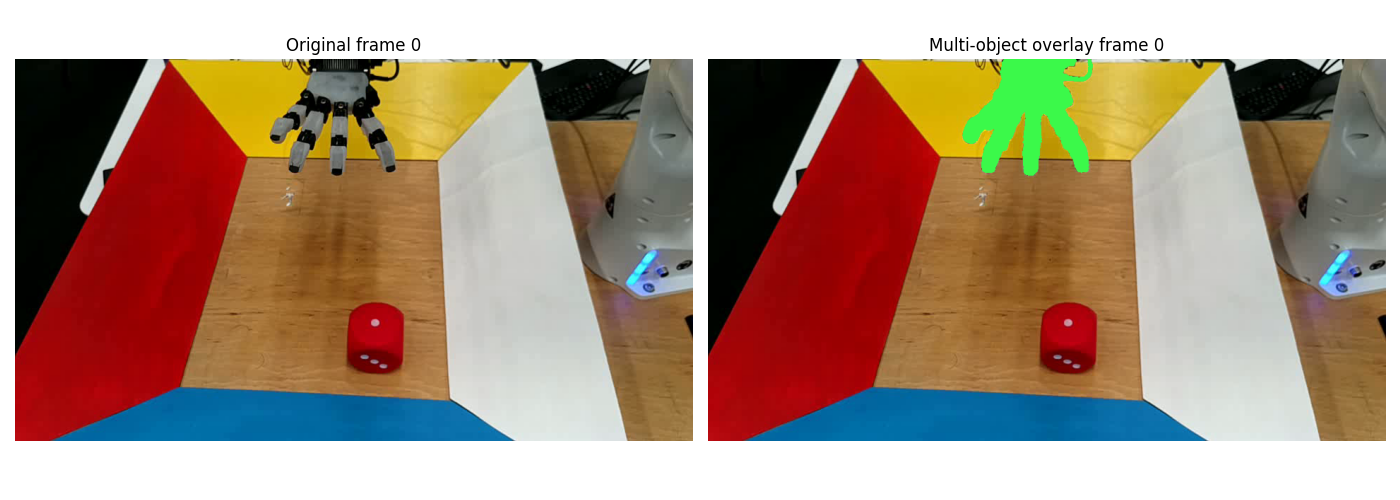

Saved overlay video to: /data/sam3_based_labeling_pipeline/assets/videos/third_view_sam3_multi_object_overlay.mp4


In [8]:
print(
    f"Final propagation processed {len(outputs_per_frame)} frames "
    f"(second pass ran: {second_pass_ran}, point refinements: {len(point_payloads)})."
)

sorted_indices = sorted(outputs_per_frame.keys())
overlay_video_frames = []
for frame_idx in sorted_indices:
    raw_frame = np.asarray(original_video_frames[frame_idx], dtype=np.uint8)
    frame_outputs = outputs_per_frame[frame_idx]
    overlay_frame = _blend_masks_on_frame(
        raw_frame,
        frame_outputs,
        object_colors_rgb=object_colors,
        alpha=MASK_ALPHA,
    )
    overlay_video_frames.append(overlay_frame)

if overlay_video_frames:
    first_idx = sorted_indices[0]
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].imshow(np.asarray(original_video_frames[first_idx], dtype=np.uint8))
    axes[0].set_title(f"Original frame {first_idx}")
    axes[0].set_axis_off()

    axes[1].imshow(overlay_video_frames[0])
    axes[1].set_title(f"Multi-object overlay frame {first_idx}")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

    media.show_video(overlay_video_frames, fps=OUTPUT_FPS)

if OUTPUT_OVERLAY_VIDEO_PATH is None:
    default_name = (
        resource_path.stem if resource_path.is_file() else resource_path.name
    )
    OUTPUT_OVERLAY_VIDEO_PATH = str(
        resource_path.parent / f"{default_name}_sam3_multi_object_overlay.mp4"
    )

media.write_video(OUTPUT_OVERLAY_VIDEO_PATH, overlay_video_frames, fps=OUTPUT_FPS)
print(f"Saved overlay video to: {OUTPUT_OVERLAY_VIDEO_PATH}")

In [ ]:
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

predictor.shutdown()